# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code from [lecture 5](https://numeconcopenhagen.netlify.com/lectures/Workflow_and_debugging).
> 1. Remember this [guide](https://www.markdownguide.org/basic-syntax/) on markdown and (a bit of) latex.
> 1. Turn on automatic numbering by clicking on the small icon on top of the table of contents in the left sidebar.
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [7]:
import numpy as np
import scipy
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

We consider a simple version of the **AS-AD model** where:

* $y_t$ is output in period t, $\bar{y}$ is natural output
* $g_t$ is government consumption in period t, $\bar{g}$ is equilibrium government consumption
* $r_t$ is the real interest rate in period t, $\bar{r}$ is the natural real interest rate
* $i_t$ is the nominal interest rate in period t
* $\pi_t$ is inflation in period t, $\pi^{e}_{t+1}$ is expected inflation in period t+1, $\pi^*$ is target inflation
* $z_t$ is a demand shock, initially assumed to be 0
* $s_t$ is a supply shock, initially assumed to be 0


The **goods market equilibrium** is stated as:

$$ y_t-\bar{y} = \alpha_1 (g_t-\bar{g}) -\alpha_2(r_t-\bar{r}) + v_t $$

The **Taylor rule** is stated as:

$$ i_t = \bar{r_t} + \pi^{e}_{t+1}+h(\pi_t-\pi^*)+b(y_t-\bar{y}) $$

and the **Fisher equation** is given by:

$$r_t=i_t-\pi^e_{t+1}$$

By defining $\hat{x_t}=x_t-\bar{x}$ for all variables and $\hat{\pi_t}=\pi_t-\pi^*$, the **AD curve** then becomes

$$ \hat{y_t} = -\alpha\hat{\pi_t}+z_t $$
$$ \hat{\pi_t} = -\frac{1}{\alpha}\hat{y_t}+\frac{1}{\alpha}z_t $$

where:

$$ \alpha \equiv \frac{\alpha_2h}{1+\alpha_2b}$$ and $$z_t\equiv \frac{\alpha_1\hat{g_t}+v_t}{1+\alpha_2b}$$


The **SRAS curve** with static expectations is described by:

$$\pi_t = \pi_{t-1}+\gamma\hat{y_t}+s_t$$

Subtracting the inflation target from both sides of the equation, we can write the SRAS curve as:

$$\hat{\pi_t} = \hat{\pi_{t-1}}+\gamma\hat{y_t}+s_t$$


# Model setup and symbolic solution
We begin by defining the symbols we will use:

In [2]:
y_hat = sm.symbols('y^hat_t')
pi_hat = sm.symbols('pi^hat_t')
pi_hat_last = sm.symbols('pi^hat_t-1')
gamma = sm.symbols('gamma')
s = sm.symbols('s_t')
alpha = sm.symbols('alpha')
z = sm.symbols('z_t')

Then we define the **AD-curve** and the **SRAS-curve**

In [3]:
AD = sm.Eq(pi_hat,(-1/alpha*y_hat+1/alpha*z))
SRAS = sm.Eq(pi_hat, (pi_hat_last+gamma*y_hat+s)) 
display(AD,SRAS)

Eq(pi^hat_t, -y^hat_t/alpha + z_t/alpha)

Eq(pi^hat_t, gamma*y^hat_t + pi^hat_t-1 + s_t)

and **solve** AS = AD for $\hat{\pi_t}$ and $\hat{y_t}$:

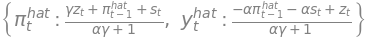

In [4]:
sm.init_printing()
sol = sm.solve([AD,SRAS],(y_hat,pi_hat))
sol

We turn the AD and the SRAS curves as well as the equilibrium into functions to use in the plot below:

In [5]:
#Redefining the AD and SRAS curves as functions
AD_func = sm.lambdify((alpha,y_hat,z), (z-y_hat)/(alpha))
SRAS_func = sm.lambdify((gamma,y_hat,pi_hat_last,s), gamma*y_hat+pi_hat_last+s)

#Defining the sympy-solution as functions for the equilibrium
pi_func = sm.lambdify((alpha,gamma,pi_hat_last,z,s),sol[pi_hat])
y_func =  sm.lambdify((alpha,gamma,pi_hat_last,z,s),sol[y_hat])

# Plotting the equilibrium

Now we set up a plot of the AS and AD curves (and the equilibrium values of $\hat{\pi_t}$ and $\hat{y_t}$):

In [12]:
def eq_plot(alpha_1=0.5,alpha_2=0.5,h=0.5,b=0.5,g_hat=0,v=0,gamma=0.5,pi_hat_last=0,s=0):
    #define parameters
    alpha = (alpha_2*h)/(1+alpha_2*b)
    z = (alpha_1*g_hat+v)/(1+alpha_2*b)
    
    #plot equilibrium point
    pi_star = pi_func(alpha,gamma,pi_hat_last,z,s)
    y_star = y_func(alpha,gamma,pi_hat_last,z,s)
    plt.plot(y_star,pi_star, marker='o', markersize=5, color="red")
    
    #plot AS and AD curves
    y_hat = np.arange(-10,10, 0.1)
    SRAS = SRAS_func(gamma,y_hat,pi_hat_last,s) 
    AD = AD_func(alpha,y_hat,z) 
    plt.plot(y_hat,SRAS)
    plt.plot(y_hat, AD)
    
    #set up plot
    plt.xlabel('$\hat{y}_t$')
    plt.ylabel('$\hat{\pi}_t$')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.legend(["equilibrium","SRAS","AD"])
    plt.show()
    return [y_star, pi_star]
    
widgets.interact(eq_plot, 
                alpha_1 = (0.001,1,0.01),
                alpha_2 = (0.001,1,0.01),
                h = (0.001,1,0.01),
                b = (0.001,1,0.01),
                v = (0.001,1,0.01),
                g_hat = (0.001,1,0.01),
                gamma = (0, 1,0.01),
                pi_hat_last = (-1,1,0.01),
                z = (-1,1,0.01),
                s = (-1,1,0.01))

interactive(children=(FloatSlider(value=0.5, description='alpha_1', max=1.0, min=0.001, step=0.01), FloatSlide…

<function __main__.eq_plot(alpha_1=0.5, alpha_2=0.5, h=0.5, b=0.5, g_hat=0, v=0, gamma=0.5, pi_hat_last=0, s=0)>

In [14]:
def SRAS(t):
    pi_hat = SRAS(t-1)+gamma*y_hat+s
    return pi_hat

**Lav AD og SRAS til funktioner man kan plotte og lav plot hvor man kan skrue på parameterværdier**

**Udvid model med flere parametre / numerical optimization på en eller anden måde**

# Steady state

## Analytical solution

We can use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] $$

First we define all **symbols**:

In [2]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

Then we define the **steady state equation**

In [3]:
ss = sm.Eq(k,(s*k**alpha+(1-delta)*k)/((1+n)*(1+g)))

and **solve** it

In [4]:
kss = sm.solve(ss,k)[0]
kss

((delta + g*n + g + n)/s)**(1/(alpha - 1))

For later use, we turn the solution into a **Python funciton**

In [5]:
ss_func = sm.lambdify((s,g,n,alpha,delta),kss)

## Numerical solution

We can re-write the equation for the steady state capital per capita as

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

whereby it clearly becomes a **root-finding problem**. Such a problem can be solved by a **bisection method**.

Define the model **parameters**:

In [6]:
s = 0.2
g = 0.02
n = 0.01
alpha = 1/3
delta = 0.1

**Solve numerically** for the steady state:

In [7]:
solution = modelproject.solve_for_ss(s,g,n,alpha,delta)

print(f'analytical solution is: {ss_func(s,g,n,alpha,delta):.3f}')
print(f' numerical solution is: {solution.root:.3f}')

analytical solution is: 1.904
 numerical solution is: 1.904


# Further analysis

ADD FURTHER ANALYSIS, VISUALIZATIONS AND EXTENSIONS.

# Conclusion

ADD CONCISE CONCLUSION.